In [1]:
from __future__ import annotations

import itertools
import math
from pathlib import Path
import re
from typing import Any, Iterable, Optional, Union
import warnings
import sys

import geopandas
import matplotlib
import matplotlib.axes
import matplotlib.cm
import matplotlib.figure
import matplotlib.pyplot
import mpl_toolkits.mplot3d
import numpy
import pandas
import plotly.graph_objs
# import seaborn
from shapely import Point
from sklearn.linear_model import LinearRegression
from scipy.optimize import Bounds
import scipy.stats

sys.path.append('../Packages/tectoniq')
from tectoniq.datasets import Mercedes
from tectoniq.functions import IFunction, Polynomial, Power, PowerWithOffset
from tectoniq.geometry import distance, distance_to_line, distance_to_line_segment
from tectoniq.optimization import fit_function


from sklearn import metrics
%load_ext autoreload
%autoreload 2

In [2]:
AREA_ID_COLUMN = Mercedes.AREA_ID_COLUMN
DOMAIN_ID_COLUMN = Mercedes.DOMAIN_ID_COLUMN
DOMAIN_NAME_COLUMN = Mercedes.DOMAIN_NAME_COLUMN
GEOMETRY_COLUMN = Mercedes.GEOMETRY_COLUMN
ID_COLUMN = Mercedes.ID_COLUMN
RADIUS: float = 20
SAMPLE_COUNT_THRESHOLD: int = 20
TARGET_COLUMN: str = "Au (ppm)"
THRESHOLD: float = 3

COPPER_COLUMN: str = "Cu (ppm)"
GOLD_COLUMN: str = "Au (ppm)"

COLUMN_FIT_OPTIONS: dict[str, dict[str, Any]] = {
    "(2Ca+Na+K)/Al": {},
    "K/Al": {},
    "As/Al": {},
    "K/(Al-Na)": {},
    "CCPI": {},
    "Ishikawa": {},
    "Na/Al": {},
    "Fe (%)": {},
    "Ca (%)": {},
    "Na (%)": {},
    "K (%)": {},
    "Al (%)": {},
    "As (ppm)": {},
    "Cu (ppm)": {},
    "Mg (%)": {}
}
COLUMN_LIMITS: dict[str, tuple[float, float]] = {
    "(2Ca+Na+K)/Al": (0, 2.5),
    "K/Al": (0, 1.5),
    "As/Al": (0, 2000),
    "K/(Al-Na)": (-0.25, 1.5),
    "CCPI": (0, 1),
    "Ishikawa": (0, 100),
    "Na/Al": (0, 1.5),
    "Fe (%)": (0, 10),
    "Ca (%)": (0, 30),
    "Na (%)": (0, 10),
    "K (%)": (0, 10),
    "Al (%)": (0, 10),
    "As (ppm)": (0, 600),
    "Cu (ppm)": (0, 300),
    "Mg (%)": (0, 5),
}

PLOT_TYPE_DENSITY: str = "density"

RATIO_COLUMNS: list[str] = ["(2Ca+Na+K)/Al", "K/Al", "As/Al", "K/(Al-Na)", "CCPI", "Ishikawa", "Na/Al"]
RATIO_CONSTITUTENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "As (ppm)", "Cu (ppm)", "Mg (%)"]
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)"]
# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)"]
# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)", "Ishikawa", "CCPI"]

DOMAIN_1_SUBSET_LINE: tuple[Point, Point] = Point(549250, 3356800), Point(550000, 3355500)
NULL_DOMAIN_BOTTOM_LEFT = Point(551200, 3355600)
NULL_DOMAIN_TOP_RIGHT = Point(551500, 3355850)

AREA_1_RHYOLITE_SAMPLE_NUMBER = "MRS-016"
AREA_1_ANDESITE_SAMPLE_NUMBER = "MRS-032"
AREA_1_ORE_SAMPLE_NUMBER = "MRS-001"
AREA_2_LIMESTONE_SAMPLE_NUMBER = "MRS-023"
AREA_2_SILTSTONE_SAMPLE_NUMBER = "M023228"
KEY_SAMPLE_NUMBERS = [AREA_1_RHYOLITE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_ORE_SAMPLE_NUMBER, AREA_2_LIMESTONE_SAMPLE_NUMBER, AREA_2_SILTSTONE_SAMPLE_NUMBER]

matplotlib.interactive(True)
warnings.filterwarnings("ignore")

In [3]:
def get_units(column: str) -> Optional[str]:
    unit_match: re.Match = re.search(r"\((.+)\)", column)
    return unit_match.group() if unit_match else None

In [4]:
data_frame: geopandas.GeoDataFrame = Mercedes.latest(Path("../Data"))

domain_1_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 1]
domain_2_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 2]
domain_3_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 3]
domain_4_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 4]
area_1_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 1]
area_2_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 2]
key_samples_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[ID_COLUMN].isin(KEY_SAMPLE_NUMBERS)]


AREA_1_RHYOLITE_SAMPLE_NUMBER = "MRS-016"
AREA_1_ANDESITE_SAMPLE_NUMBER = "MRS-032"
AREA_1_ORE_SAMPLE_NUMBER = "MRS-001"
AREA_2_LIMESTONE_SAMPLE_NUMBER = "MRS-023"
AREA_2_SILTSTONE_SAMPLE_NUMBER = "M023228"

In [133]:
area_1_data_frame['seq'] = area_1_data_frame[RATIO_COLUMNS].round(3).apply(lambda row: ' '.join(map(str, row)), axis=1)

In [134]:
area_1_data_frame = area_1_data_frame[area_1_data_frame.index.isin(area_1_data_frame[RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS].dropna().index)] 

In [135]:
area_1_data_frame[RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS + ['seq']].round(3)

,(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),seq
0,0.658,0.548,4.372,0.565,0.779,88.052,0.029,1.25,0.22,0.16,3.01,5.49,24.0,12.0,0.14,0.658 0.548 4.372 0.565 0.779 88.052 0.029
1,0.769,0.578,6.424,0.597,0.748,83.211,0.031,1.75,0.46,0.18,3.33,5.76,37.0,12.0,0.23,0.769 0.578 6.424 0.597 0.748 83.211 0.031
2,0.604,0.501,11.075,0.514,0.857,88.684,0.026,2.13,0.24,0.16,3.12,6.23,69.0,18.0,0.34,0.604 0.501 11.075 0.514 0.857 88.684 0.026
3,0.605,0.532,7.827,0.544,0.885,91.473,0.022,2.14,0.16,0.14,3.33,6.26,49.0,13.0,0.25,0.605 0.532 7.827 0.544 0.885 91.473 0.022
4,0.654,0.463,11.215,0.496,0.756,78.889,0.067,2.21,0.40,0.43,2.97,6.42,72.0,23.0,0.41,0.654 0.463 11.215 0.496 0.756 78.889 0.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,0.917,0.881,50.075,0.897,0.898,96.674,0.018,1.61,0.06,0.12,5.86,6.65,333.0,16.0,0.05,0.917 0.881 50.075 0.897 0.898 96.674 0.018
3393,0.761,0.735,46.075,0.744,0.947,97.279,0.012,1.93,0.04,0.07,4.31,5.86,270.0,14.0,0.11,0.761 0.735 46.075 0.744 0.947 97.279 0.012
3394,0.952,0.858,43.363,0.882,0.843,92.882,0.027,1.75,0.19,0.15,4.85,5.65,245.0,16350.0,0.16,0.952 0.858 43.363 0.882 0.843 92.882 0.027
3395,0.557,0.498,24.378,0.503,0.890,93.163,0.010,0.52,0.05,0.02,1.00,2.01,49.0,84.0,0.07,0.557 0.498 24.378 0.503 0.89 93.163 0.01


In [136]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel

def create_embeddings(texts):
    # Load tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Tokenize texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract embeddings from the model output
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()

    return embeddings

In [137]:
texts = area_1_data_frame['seq'].tolist()
embeddings = create_embeddings(texts)

In [139]:
area_1_data_frame['embeddings'] = list(embeddings)

In [140]:
area_1_data_frame[[GOLD_COLUMN] + RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS + ['embeddings']].round(3)

,Au (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),embeddings
0,0.006,0.658,0.548,4.372,0.565,0.779,88.052,0.029,1.25,0.22,0.16,3.01,5.49,24.0,12.0,0.14,"[-0.40369347, -0.3166528, 0.09858912, -0.29288..."
1,0.002,0.769,0.578,6.424,0.597,0.748,83.211,0.031,1.75,0.46,0.18,3.33,5.76,37.0,12.0,0.23,"[-0.3893635, -0.27557787, 0.038910154, -0.3407..."
2,0.002,0.604,0.501,11.075,0.514,0.857,88.684,0.026,2.13,0.24,0.16,3.12,6.23,69.0,18.0,0.34,"[-0.49043238, -0.39676154, 0.053150646, -0.363..."
3,0.010,0.605,0.532,7.827,0.544,0.885,91.473,0.022,2.14,0.16,0.14,3.33,6.26,49.0,13.0,0.25,"[-0.5097841, -0.42555282, 0.06026476, -0.45105..."
4,0.002,0.654,0.463,11.215,0.496,0.756,78.889,0.067,2.21,0.40,0.43,2.97,6.42,72.0,23.0,0.41,"[-0.4639627, -0.33639917, 0.07258496, -0.33037..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,3.600,0.917,0.881,50.075,0.897,0.898,96.674,0.018,1.61,0.06,0.12,5.86,6.65,333.0,16.0,0.05,"[-0.42653155, -0.3471376, 0.039637633, -0.3478..."
3393,0.284,0.761,0.735,46.075,0.744,0.947,97.279,0.012,1.93,0.04,0.07,4.31,5.86,270.0,14.0,0.11,"[-0.41610485, -0.35166463, 0.038357783, -0.355..."
3394,0.072,0.952,0.858,43.363,0.882,0.843,92.882,0.027,1.75,0.19,0.15,4.85,5.65,245.0,16350.0,0.16,"[-0.476336, -0.31750676, 0.08498593, -0.390657..."
3395,0.007,0.557,0.498,24.378,0.503,0.890,93.163,0.010,0.52,0.05,0.02,1.00,2.01,49.0,84.0,0.07,"[-0.3259719, -0.23282723, 0.060475722, -0.2668..."


In [203]:
from sklearn.preprocessing import StandardScaler

def normalize_embeddings(embeddings):
    """
    Normalize embeddings using StandardScaler.
    
    Parameters:
    embeddings (numpy.ndarray): Embeddings matrix of shape (n_samples, n_features).
    
    Returns:
    numpy.ndarray: Normalized embeddings matrix.
    """
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    return normalized_embeddings

In [204]:
normalized_embeddings = normalize_embeddings(embeddings)

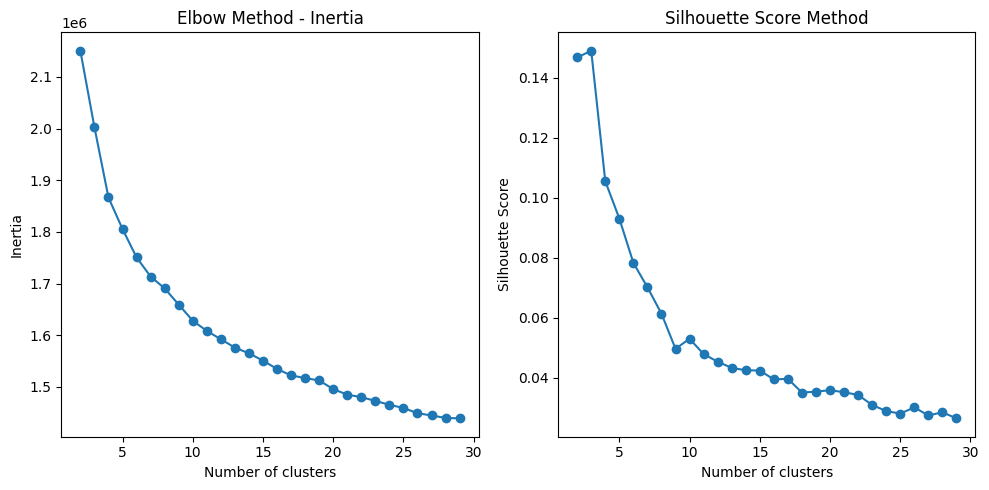

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'embeddings' is your array of embeddings

# Define a range of K values to test
k_range = range(2, 30)  # Test from 2 to 10 clusters

# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# Iterate over each K value
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalize_embeddings)
    
    # Append the inertia and silhouette score to the lists
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(normalize_embeddings, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(10, 5))

# Plotting Inertia
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia')

# Plotting Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()

In [205]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K,random_state=0).fit(normalized_embeddings)
cls_dist=pandas.Series(kmeans.labels_).value_counts()

In [206]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = numpy.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, area_1_data_frame.iloc[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		226		1874		SampleNumber                                              M001374
Easting                                                  549915.0
Northing                                                3355802.0
Latitude                                                30.333022
Longitude                                             -110.480727
                                      ...                        
AreaId                                                        1.0
seq                      72.0 17.5 300.0 -0.357 0.365 45.286 50.0
embeddings      [-0.21726377, -0.25566265, 0.035507668, -0.165...
cluster                                                         3
Au >= 3                                                         0
Name: 1874, Length: 76, dtype: object
1		1360		2404		SampleNumber                                              M022140
Easting                                                  548880.0
Northing                         

[1 1 3 ... 1 2 2]
[16.601044 16.11718  15.974263 ... 15.271763 17.323584 16.564438]


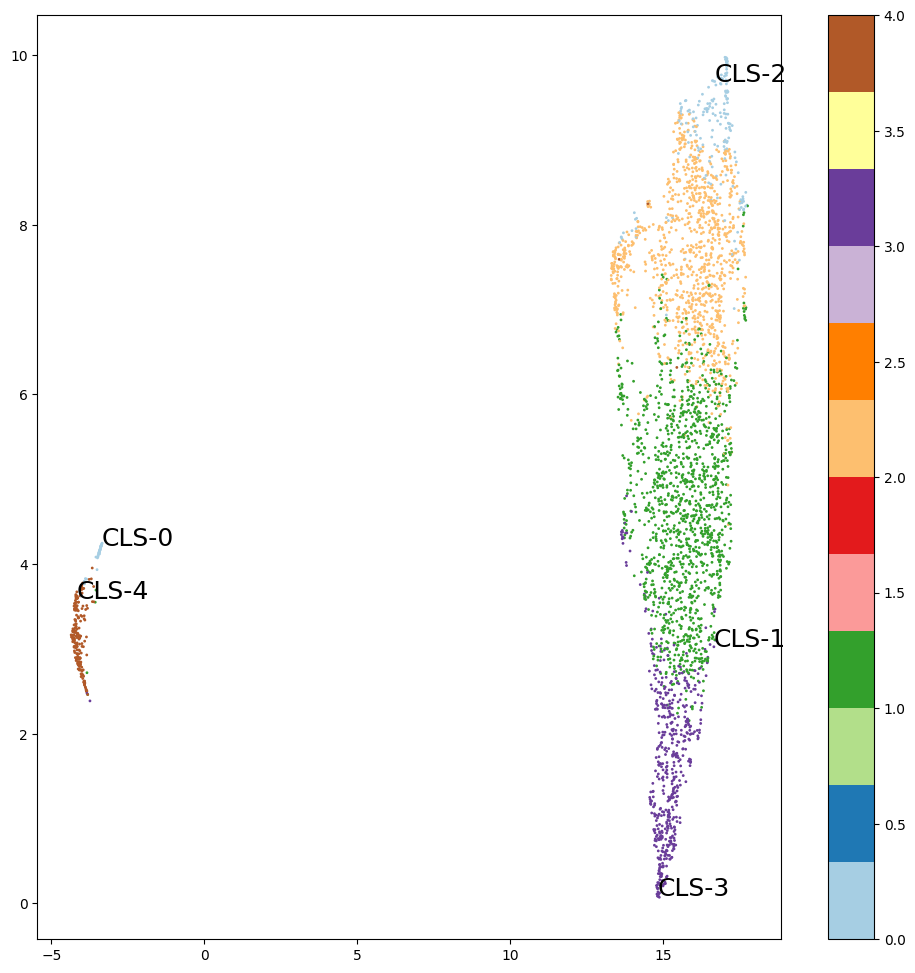

In [207]:
import matplotlib.pyplot as plt
import umap
X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(embeddings)
labels= kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(12,12))
print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=18)
plt.colorbar()

In [159]:
cls_dist=pandas.Series(kmeans.labels_).value_counts()

In [160]:
pandas.Series(kmeans.labels_).value_counts()

2    626
7    557
1    556
6    402
9    374
5    311
4    223
3    127
8    112
0    109
Name: count, dtype: int64

In [208]:
area_1_data_frame = area_1_data_frame.reset_index(drop=True)

In [209]:
area_1_data_frame['cluster'] = pandas.Series(kmeans.labels_)

In [210]:
area_1_data_frame[area_1_data_frame['cluster'] == 0][RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS + ['Au (ppm)']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
(2Ca+Na+K)/Al,226.0,77.05,242.21,0.18,0.75,1.20,48.21,2501.75
K/Al,226.0,8.27,44.56,0.05,0.28,0.42,0.69,512.50
As/Al,226.0,448.15,2418.57,0.99,16.73,60.15,200.00,33800.00
K/(Al-Na),226.0,0.13,1.27,-10.96,0.20,0.37,0.58,1.17
CCPI,226.0,0.62,0.33,0.00,0.36,0.77,0.91,0.97
Ishikawa,226.0,54.98,32.74,0.11,31.56,59.66,87.53,97.77
Na/Al,226.0,6.25,17.31,0.01,0.02,0.08,0.25,100.00
Fe (%),226.0,1.51,1.21,0.07,0.64,1.00,2.08,5.68
Ca (%),226.0,3.51,7.51,0.01,0.09,0.24,1.75,35.50
Na (%),226.0,1.51,4.19,0.00,0.02,0.06,0.60,37.00


In [212]:
area_1_data_frame[area_1_data_frame['cluster'] == 4][RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS + ['Au (ppm)']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
(2Ca+Na+K)/Al,211.0,67.18,77.57,2.68,41.63,56.67,73.33,867.37
K/Al,211.0,35.26,69.59,0.11,15.62,26.03,38.04,815.79
As/Al,211.0,236.98,346.51,6.67,73.90,142.37,287.30,3771.43
K/(Al-Na),211.0,-1.81,2.77,-29.27,-2.06,-1.07,-0.54,0.12
CCPI,211.0,0.40,0.18,0.05,0.27,0.36,0.51,0.98
Ishikawa,211.0,58.98,16.37,3.50,48.84,59.66,69.12,98.41
Na/Al,211.0,26.62,17.06,0.09,14.12,23.40,36.04,85.71
Fe (%),211.0,1.73,1.49,1.00,1.00,1.00,2.00,10.00
Ca (%),211.0,0.97,1.76,0.10,0.20,0.50,1.00,15.50
Na (%),211.0,10.76,10.77,0.04,4.00,8.00,13.00,68.00


In [222]:
area_1_data_frame[area_1_data_frame['cluster'] == 3][RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS+ ['Au (ppm)', 'Au >= 3']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
(2Ca+Na+K)/Al,529.0,4.24,24.98,0.20,0.75,0.90,1.07,455.45
K/Al,529.0,0.74,1.20,0.03,0.56,0.68,0.83,27.78
As/Al,529.0,34.72,53.25,0.33,10.92,22.33,41.71,775.00
K/(Al-Na),529.0,0.72,0.33,-4.55,0.60,0.72,0.87,1.19
CCPI,529.0,0.78,0.20,0.01,0.74,0.86,0.90,0.96
Ishikawa,529.0,80.65,21.75,0.47,77.79,89.17,93.60,97.28
Na/Al,529.0,0.10,0.73,0.00,0.02,0.03,0.07,16.67
Fe (%),529.0,2.30,1.28,0.20,1.11,2.26,3.41,7.85
Ca (%),529.0,1.22,4.13,0.02,0.09,0.21,0.45,34.40
Na (%),529.0,0.37,0.57,0.00,0.08,0.14,0.31,3.77


In [52]:
area_1_data_frame['Au >= 3'] = (area_1_data_frame['Au (ppm)'] >= 3).astype(int)

In [77]:
area_1_data_frame[area_1_data_frame['Au (ppm)'] >= 3].shape

(95, 76)

In [78]:
area_1_data_frame['Au >= 3'].value_counts()

Au >= 3
0    3302
1      95
Name: count, dtype: int64